# ChemBERTA

In this module, we use ChemBERTAa-77M-MTR to extract embeddings from compound SMILES.

## Setup

In [32]:
#|default_exp berta

In [33]:
#| export
import torch, numpy as np, pandas as pd,torch.nn as nn
from tqdm import tqdm
from transformers import AutoModelForMaskedLM, AutoTokenizer

## Feature extraction

Referenced from:
- [ChemBERTA2 paper](https://arxiv.org/abs/2209.01712)
- [HuggingFace model: ChemBERTA-77M-MTR](https://huggingface.co/DeepChem/ChemBERTa-77M-MTR)
- [Kaggle discussion: ChemBERTa v2 Embeddings for smiles, comments from MT](https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/441550)
- [Kaggle notebook: create_ChemBERTa_embed](https://www.kaggle.com/code/alekseytrepetsky/create-chemberta-embed)
- [1st place solution single cell pbs](https://github.com/Jean-KOUAGOU/1st-place-solution-single-cell-pbs/blob/main/helper_functions.py)

In [34]:
#| export
@torch.no_grad()
def get_chemberta(df: pd.DataFrame, # dataframe that contains SMILES
                  smi_col: str, # colname of SMILES
                  combine: bool=True, # whether or not combine the mean embeddings and CLS token embedding
                 ):
    
    model = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

    inputs=tokenizer(df[smi_col].tolist(),return_tensors="pt",padding=True,truncation=True)

    # disable the lm_head so that we only get the transformer output
    model.lm_head =nn.Identity()
    

    out = model(**inputs)[0] # get the logits of the input

    # Get the mean of embeddings
    mean = out.mean(1).numpy()

    # CLS token embedding, from the first token of the seq
    cls = out[:,0,:].numpy()

    if combine:
        emb = np.concatenate([mean,cls],axis=-1)
        emb_df = pd.DataFrame(emb)
        emb_df.columns = 'chemberta_'+emb_df.columns.astype(str)
        emb_df.index=df.index
        return emb_df

    else:
        cls_df = pd.DataFrame(cls)
        mean_df = pd.DataFrame(mean)

        cls_df.columns = 'chemberta_'+cls_df.columns.astype(str)
        mean_df.columns = 'chemberta_'+mean_df.columns.astype(str)

        cls_df.index, mean_df =df.index,df.index

    return cls_df, mean_df

In [18]:
df = pd.read_csv('dataset/all2.csv')

In [19]:
df.head()

,ID,SMILES,Kd,IC50,erk_IC50
0,US_284,Oc1cc(Cl)c(C(F)(F)F)c(-c2ncc3c(N4CC5CCC(C4)N5)nc(OC[C@@]45CCCN4C[C@H](F)C5)nc3c2F)c1,NaN,0.1,17.4
1,31678_45,C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(NCC5(N(C)C)CCC5)nc(OC[C@]56CCCN5[C@@H](COC(=O)N(C)C)CC6)nc4c3F)c12,NaN,0.4,38.3
2,US_243,C#Cc1cccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)nc(OC[C@@]56CCCN5C[C@H](F)C6)nc4c3F)c12,NaN,0.4,0.8
3,US_340,Oc1ccc(OC(F)(F)F)c(-c2ncc3c(N4CC5CCC(C4)N5)nc(OCC45CCCN4C[C@H](F)C5)nc3c2F)c1,NaN,0.4,51.5
4,US_439,C#Cc1c(F)ccc2cccc(-c3ncc4c(N5CC6CCC(C5)N6)nc(OC[C@]56CCCN5[C@@H](COC(=O)N(C)C)CC6)nc4c3F)c12,NaN,0.4,12.8


Make a datahub first

Standardize smiles first

In [20]:
feat = get_chemberta(df,'SMILES')

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MTR were not used when initializing RobertaForMaskedLM: ['regression.dense.weight', 'regression.out_proj.bias', 'regression.out_proj.weight', 'regression.dense.bias', 'norm_mean', 'norm_std']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
You should proba

In [22]:
feat.head()

,chemberta_0,chemberta_1,chemberta_2,chemberta_3,chemberta_4,chemberta_5,chemberta_6,chemberta_7,chemberta_8,chemberta_9,chemberta_10,chemberta_11,chemberta_12,chemberta_13,chemberta_14,chemberta_15,chemberta_16,chemberta_17,chemberta_18,chemberta_19,chemberta_20,chemberta_21,chemberta_22,chemberta_23,chemberta_24,chemberta_25,chemberta_26,chemberta_27,chemberta_28,chemberta_29,chemberta_30,chemberta_31,chemberta_32,chemberta_33,chemberta_34,chemberta_35,chemberta_36,chemberta_37,chemberta_38,chemberta_39,chemberta_40,chemberta_41,chemberta_42,chemberta_43,chemberta_44,chemberta_45,chemberta_46,chemberta_47,chemberta_48,chemberta_49,chemberta_50,chemberta_51,chemberta_52,chemberta_53,chemberta_54,chemberta_55,chemberta_56,chemberta_57,chemberta_58,chemberta_59,chemberta_60,chemberta_61,chemberta_62,chemberta_63,chemberta_64,chemberta_65,chemberta_66,chemberta_67,chemberta_68,chemberta_69,chemberta_70,chemberta_71,chemberta_72,chemberta_73,chemberta_74,chemberta_75,chemberta_76,chemberta_77,chemberta_78,chemberta_79,chemberta_80,chemberta_81,chemberta_82,chemberta_83,chemberta_84,chemberta_85,chemberta_86,chemberta_87,chemberta_88,chemberta_89,chemberta_90,chemberta_91,chemberta_92,chemberta_93,chemberta_94,chemberta_95,chemberta_96,chemberta_97,chemberta_98,chemberta_99,chemberta_100,chemberta_101,chemberta_102,chemberta_103,chemberta_104,chemberta_105,chemberta_106,chemberta_107,chemberta_108,chemberta_109,chemberta_110,chemberta_111,chemberta_112,chemberta_113,chemberta_114,chemberta_115,chemberta_116,chemberta_117,chemberta_118,chemberta_119,chemberta_120,chemberta_121,chemberta_122,chemberta_123,chemberta_124,chemberta_125,chemberta_126,chemberta_127,chemberta_128,chemberta_129,chemberta_130,chemberta_131,chemberta_132,chemberta_133,chemberta_134,chemberta_135,chemberta_136,chemberta_137,chemberta_138,chemberta_139,chemberta_140,chemberta_141,chemberta_142,chemberta_143,chemberta_144,chemberta_145,chemberta_146,chemberta_147,chemberta_148,chemberta_149,chemberta_150,chemberta_151,chemberta_152,chemberta_153,chemberta_154,chemberta_155,chemberta_156,chemberta_157,chemberta_158,chemberta_159,chemberta_160,chemberta_161,chemberta_162,chemberta_163,chemberta_164,chemberta_165,chemberta_166,chemberta_167,chemberta_168,chemberta_169,chemberta_170,chemberta_171,chemberta_172,chemberta_173,chemberta_174,chemberta_175,chemberta_176,chemberta_177,chemberta_178,chemberta_179,chemberta_180,chemberta_181,chemberta_182,chemberta_183,chemberta_184,chemberta_185,chemberta_186,chemberta_187,chemberta_188,chemberta_189,chemberta_190,chemberta_191,chemberta_192,chemberta_193,chemberta_194,chemberta_195,chemberta_196,chemberta_197,chemberta_198,chemberta_199,chemberta_200,chemberta_201,chemberta_202,chemberta_203,chemberta_204,chemberta_205,chemberta_206,chemberta_207,chemberta_208,chemberta_209,chemberta_210,chemberta_211,chemberta_212,chemberta_213,chemberta_214,chemberta_215,chemberta_216,chemberta_217,chemberta_218,chemberta_219,chemberta_220,chemberta_221,chemberta_222,chemberta_223,chemberta_224,chemberta_225,chemberta_226,chemberta_227,chemberta_228,chemberta_229,chemberta_230,chemberta_231,chemberta_232,chemberta_233,chemberta_234,chemberta_235,chemberta_236,chemberta_237,chemberta_238,chemberta_239,chemberta_240,chemberta_241,chemberta_242,chemberta_243,chemberta_244,chemberta_245,chemberta_246,chemberta_247,chemberta_248,chemberta_249,chemberta_250,chemberta_251,chemberta_252,chemberta_253,chemberta_254,chemberta_255,chemberta_256,chemberta_257,chemberta_258,chemberta_259,chemberta_260,chemberta_261,chemberta_262,chemberta_263,chemberta_264,chemberta_265,chemberta_266,chemberta_267,chemberta_268,chemberta_269,chemberta_270,chemberta_271,chemberta_272,chemberta_273,chemberta_274,chemberta_275,chemberta_276,chemberta_277,chemberta_278,chemberta_279,chemberta_280,chemberta_281,chemberta_282,chemberta_283,chemberta_284,chemberta_285,chemberta_286,chemberta_287,chemberta_288,chemberta_289,chemberta_290,chemberta_291,chemberta_292,chember

## Visualize

In [23]:
# !pip install git+https://github.com/sky1ove/katlas.git -Uqq

In [24]:
from katlas.feature import *
from katlas.plot import *

In [25]:
feat = preprocess(feat)

removing columns: {'chemberta_756'}


/usr/local/lib/python3.9/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


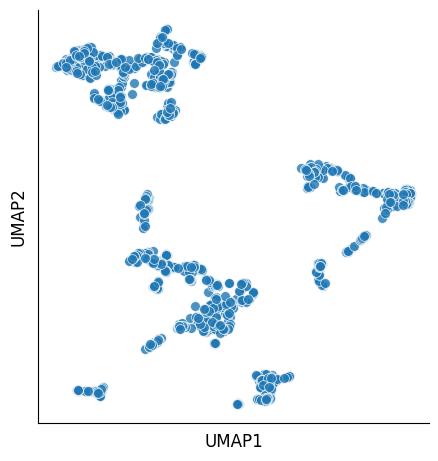

In [26]:
plot_cluster(feat,'umap',complexity=15)

In [35]:
#| hide
import nbdev; nbdev.nbdev_export()